In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/t5-shakespeare-model-checkpoint/kaggle.json
/kaggle/input/shakespearify/final.csv


In [2]:
! pip install evaluate nltk pandas matplotlib rouge_score bert_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.3 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ae552a2f4eb11acc941fe9c6a488c81c84f85a7e779f74f3b625e7802c8ab755
  St

In [3]:
! pip install transformers datasets

In [4]:
! pip install spacy
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import kagglehub
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import evaluate
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

2025-06-24 18:37:34.224897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750790254.427220      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750790254.487471      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
# Download latest version
path = kagglehub.dataset_download("garnavaurha/shakespearify")

print("Path to dataset files:", path)

# Load the dataset into a pandas DataFrame
df = pd.read_csv(f"{path}/final.csv")

df.head()

Path to dataset files: /kaggle/input/shakespearify


,Unnamed: 0,id,og,t
0,0,42928-1500614319216-63344,You do not meet a man but frowns:,Every man you meet these days is frowning.
1,1,42928-1500614326583-89821,our bloods No more obey the heavens than our...,Our bodies are in agreement with the planetar...
2,2,A-63849,But what's the matter?,What's wrong?
3,3,42930-1500614347266-80123,"His daughter, and the heir of's kingdom, whom...","The king wanted his daughter, the only heir to..."
4,4,42930-1500614355280-38326,she's wedded; Her husband banish'd; she impr...,"She's married, her husband is banished, she's..."


In [7]:
# Rename columns
df = df.rename(columns={'t': 'modern', 'og': 'shakespeare'})

In [8]:
# 2. Wrap in HF Dataset

from datasets import Dataset, DatasetDict

# df_small = df.iloc[:5000]

# Assuming df is your pandas DataFrame initially
dataset_raw = Dataset.from_pandas(df)  # Convert once at start

# Filter out examples where either text is too long
def filter_too_long(example, max_char_len=256):
    return len(example["modern"]) <= max_char_len and len(example["shakespeare"]) <= max_char_len

dataset = dataset_raw.filter(filter_too_long)

print(f"Original dataset size: {len(dataset_raw)}")
print(f"Filtered dataset size: {len(dataset)}")

# First split: train and temp (val+test)
split_1 = dataset.train_test_split(test_size=0.1, seed=42)

# Second split: temp split into val and test (50%-50%)
split_2 = split_1['test'].train_test_split(test_size=0.5, seed=42)

# Compose final dataset dict
dataset = DatasetDict({
    "train": split_1["train"],
    "validation": split_2["train"],
    "test": split_2["test"]
})

print(f"Train size: {len(dataset['train'])}")
print(f"Validation size: {len(dataset['validation'])}")
print(f"Test size: {len(dataset['test'])}")

Filter:   0%|          | 0/51787 [00:00<?, ? examples/s]

Original dataset size: 51787
Filtered dataset size: 51201
Train size: 46080
Validation size: 2560
Test size: 2561


In [9]:
# 3. Load BART tokenizer and model
from transformers import BartTokenizer, BartForConditionalGeneration

# 1. Load tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

# 2. Add the special style token
special_tokens_dict = {'additional_special_tokens': ['<SHAKESPEARE>']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Added {num_added_toks} special tokens")

# 3. Resize model embeddings to include new tokens
model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Added 1 special tokens


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


BartScaledWordEmbedding(50266, 1024, padding_idx=1)

In [10]:
# Define a style token
style_token = "<SHAKESPEARE>"

# Optional prefix for additional guidance
prefix = "Rewrite in Shakespeare style: "

def preprocess(examples):
    # Add style token + prefix to each input
    inputs = [f"{style_token} {prefix}{ex}" for ex in examples["modern"]]
    targets = examples["shakespeare"]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=100,
        truncation=True,
        padding="max_length"
    )

    # Tokenize targets directly (BART doesn't require as_target_tokenizer)
    labels = tokenizer(
        targets,
        max_length=100,
        truncation=True,
        padding="max_length"
    )

    # Replace padding token ID with -100 to ignore in loss
    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]

    # Add labels to the model input
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/46080 [00:00<?, ? examples/s]

Map:   0%|          | 0/2560 [00:00<?, ? examples/s]

Map:   0%|          | 0/2561 [00:00<?, ? examples/s]

In [11]:
# After tokenization:
sample = tokenized_dataset["train"][0]["labels"]
print(sample)
print(set(sample))

[0, 1437, 653, 6, 34, 42, 631, 1382, 456, 3422, 116, 1437, 1437, 2, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
{0, 34, 2, 6, 1382, 456, 42, 653, 116, 631, -100, 1437, 3422}


In [12]:
# Check truncation limit
def check_truncation(example):
    return {
        "modern_len": len(tokenizer.tokenize(example["modern"])),
        "shakespeare_len": len(tokenizer.tokenize(example["shakespeare"]))
    }

lengths = dataset["train"].map(check_truncation)
max_modern = max(lengths["modern_len"])
max_shake  = max(lengths["shakespeare_len"])
print(f"Max modern: {max_modern} | Max shakespeare: {max_shake}")

Map:   0%|          | 0/46080 [00:00<?, ? examples/s]

Max modern: 80 | Max shakespeare: 82


In [13]:
# 5. Define training args
training_args = TrainingArguments(
    output_dir="./t5-shakespeare", # save model
    eval_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=6,
    weight_decay=0.01,
    save_total_limit=1,
    save_strategy="epoch",
    # logging_dir="./logs",
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
)

In [14]:
# 6. Setup trainer
from transformers import TrainerCallback

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

class PrintMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(f"Epoch {int(state.epoch)} →", logs)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[PrintMetricsCallback()],
)

/tmp/ipykernel_18/3130968074.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
# ===========================
# 🔧 7. Train the model
# ===========================
trainer.train()

# ===========================
# 💾 Save model and tokenizer
# ===========================
model_dir = "/kaggle/working/t5-shakespeare"

# Model saving is already handled by TrainingArguments.output_dir

# Save the tokenizer explicitly
tokenizer.save_pretrained(model_dir)

# ===========================
# 🔐 Set up Kaggle API access
# ===========================
import os
import json

# Ensure the Kaggle API directory exists
os.makedirs("/root/.kaggle", exist_ok=True)

# Copy your uploaded kaggle.json file from input dataset
kaggle_json_path = "/kaggle/input/t5-shakespeare-model-checkpoint/kaggle.json"
!cp {kaggle_json_path} /root/.kaggle/kaggle.json

# Set permissions and environment variable
os.chmod("/root/.kaggle/kaggle.json", 600)
os.environ["KAGGLE_CONFIG_DIR"] = "/root/.kaggle"

# ===========================
# 🚀 Upload new dataset version
# ===========================
!kaggle datasets version -p {model_dir} \
    -d michaeladebayo99/t5-shakespeare-model-checkpoint \
    -m "New training checkpoint"

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.667300,2.342718
2,2.421400,2.249963
3,2.336800,2.203409
4,2.287600,2.176024
5,2.260500,2.163213
6,2.247900,2.159206


Epoch 1 → {'loss': 2.6673, 'grad_norm': 572859.3125, 'learning_rate': 8.333622685185184e-07, 'epoch': 1.0}
Epoch 1 → {'eval_loss': 2.3427176475524902, 'eval_runtime': 88.7212, 'eval_samples_per_second': 28.854, 'eval_steps_per_second': 3.607, 'epoch': 1.0}


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 2 → {'loss': 2.4214, 'grad_norm': 1425487.25, 'learning_rate': 6.666956018518518e-07, 'epoch': 2.0}
Epoch 2 → {'eval_loss': 2.2499632835388184, 'eval_runtime': 91.9813, 'eval_samples_per_second': 27.832, 'eval_steps_per_second': 3.479, 'epoch': 2.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 3 → {'loss': 2.3368, 'grad_norm': 1520511.125, 'learning_rate': 5.000289351851852e-07, 'epoch': 3.0}
Epoch 3 → {'eval_loss': 2.20340895652771, 'eval_runtime': 91.8051, 'eval_samples_per_second': 27.885, 'eval_steps_per_second': 3.486, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 4 → {'loss': 2.2876, 'grad_norm': 790640.625, 'learning_rate': 3.333622685185185e-07, 'epoch': 4.0}
Epoch 4 → {'eval_loss': 2.1760239601135254, 'eval_runtime': 88.67, 'eval_samples_per_second': 28.871, 'eval_steps_per_second': 3.609, 'epoch': 4.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 5 → {'loss': 2.2605, 'grad_norm': 615378.4375, 'learning_rate': 1.6669560185185186e-07, 'epoch': 5.0}
Epoch 5 → {'eval_loss': 2.163212776184082, 'eval_runtime': 91.473, 'eval_samples_per_second': 27.986, 'eval_steps_per_second': 3.498, 'epoch': 5.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch 6 → {'loss': 2.2479, 'grad_norm': 544999.9375, 'learning_rate': 2.8935185185185184e-11, 'epoch': 6.0}
Epoch 6 → {'eval_loss': 2.1592063903808594, 'eval_runtime': 91.6357, 'eval_samples_per_second': 27.937, 'eval_steps_per_second': 3.492, 'epoch': 6.0}
Epoch 6 → {'train_runtime': 28537.2448, 'train_samples_per_second': 9.688, 'train_steps_per_second': 1.211, 'total_flos': 5.8511824257024e+16, 'train_loss': 2.3702471980342157, 'epoch': 6.0}
usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: unrecognized arguments: michaeladebayo99/t5-shakespeare-model-checkpoint


In [16]:
import spacy
import random
import re

# Load spaCy English model for POS tagging
nlp = spacy.load("en_core_web_sm")

# Contraction normalization map
contraction_map = {
    "can't": "can not",
    "won't": "will not",
    "don't": "do not",
    "didn't": "did not",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "there's": "there is",
    "what's": "what is",
    "who's": "who is",
    # add more as needed
}

def normalize_contractions(text):
    for contraction, full in contraction_map.items():
        # Use word boundaries and case-insensitive replacement
        pattern = re.compile(r'\b' + re.escape(contraction) + r'\b', flags=re.IGNORECASE)
        text = pattern.sub(full, text)
    return text

phrase_mapping = {
    "thank you": ["I thank thee", "I thank ye", "Gramercy"],
    "good morning": ["Good morrow", "Morrow to thee"],
    "good evening": ["Good e'en", "Even so"],
    "do you": ["dost thou"],
    "will you": ["wilt thou"],
    "you are": ["thou art"],
    "do not": ["dost not"],
    "did not": ["didst not"],
    "that is": ["that is", "that be"],
    "what is": ["what is", "what be"],
    "who is": ["who is", "who be"],

    "oh no": ["Alack", "Alas"],
    "oh dear": ["Alack-a-day"],
    "oh my": ["Zounds", "Marry"],

    "it is": ["'tis"],
    "it was": ["'twas"],
    "it were": ["'twere"],
    "it would": ["'twould"],
    "it shall": ["'tshall"],
    "could not": ["couldst not"],
    "would not": ["wouldst not"],
    "should not": ["shouldst not"],
    "can not": ["canst not"],
    "may not": ["mayst not"],
    "shall not": ["shalt not"],
    "will not": ["wilt not"],

    "i am": ["I am", "I be"],
    "you are": ["thou art"],
    "he is": ["he is", "he be"],
    "she is": ["she is", "she be"],
    "they are": ["they are", "they be"],
    "we are": ["we are", "we be"],
    "there is": ["there is", "there be"],
    "there are": ["there are", "there be"],
    "here is": ["here is", "here be"],
    "here are": ["here are", "here be"],

    "my friend": ["mine own friend", "my good friend"],
    "my lord": ["mine own lord", "my good lord"],
    "my lady": ["mine own lady", "my good lady"],
    "my love": ["mine own love", "my true love"],
    "excuse me": ["I crave thy pardon", "Prithee pardon me"],
    "are you": ["art thou"],
    "can you": ["canst thou"],
    "should you": ["shouldst thou"],
    "how are you": ["How fares thee?", "How dost thou fare?"],
    "good day": ["Good morrow", "Good den"],
    "what do you mean": ["What meanst thou?"],
    "i don't know": ["I wot not"],
    "i think so": ["Methinks so"],
    "it seems": ["It doth seem", "It seemeth"],
    "never mind": ["No matter"],
    "of course": ["Ay, marry", "Verily"],
    "go on": ["Proceed", "On with thee"],
    "come here": ["Come hither", "Come hitherward"],
    "stand aside": ["Stand aside", "Stand thee aside"],
    "be quiet": ["Hold thy peace", "Hush"],
    "by god": ["By my troth", "By my faith"],
    "what's wrong": ["What troubles thee?", "What aileth thee?"],
    "don't worry": ["Fret not", "Cease thy fretting"],
    "i assure you": ["I warrant thee", "I assure thee"],
    "rest assured": ["Be thou assured"],

    "what's up": ["What aileth thee?", "What news?"],
    "go away": ["Away with thee"],
    
}

def phrase_replace(text, mapping):
    phrases = sorted(mapping.keys(), key=len, reverse=True)
    for phrase in phrases:
        pattern = re.compile(re.escape(phrase), re.IGNORECASE)
        def replace_func(match):
            repl = mapping[phrase]
            if isinstance(repl, list):
                repl = random.choice(repl)
            # Preserve capitalization style
            if match.group(0).istitle():
                repl = repl.capitalize()
            elif match.group(0).isupper():
                repl = repl.upper()
            return repl
        text = pattern.sub(replace_func, text)
    return text


# Map dictionary for single words
modern_to_shakespeare = {
    "you": 'thou',
    "your": "thy",
    "yours": "thine",
    "yourself": "thyself",
    "i": "I",
    "do": "dost",
    "does": "doth",
    "have": "hast",
    "has": "hath",
    "are": "art",
    "were": "wert",
    
    # ... extended from contractions
    "never": "ne'er",
    "ever": "e'er",
    "over": "o'er",
    "before": "ere",
    "often": "oft",
    "perhaps": "perchance",
    "maybe": "haply",
    "soon": "anon",

    # ... extended from emotions
    "oh": "O",
    "wow": "Marry",
    
    # Miscellaneous
    "stop": "cease",
    "stop": "hold",
    "listen": "hark",
    "listen": "mark me",
    "help me": "aid me",
    "indeed": "forsooth",
    "yes": "yea",
    "no": "nay",
    "think": "bethink",
    "know": "wot",
    "understand": "ken",
    "give": "bestow",
    "go": "hie",
    "come": "approach",
    "leave": "depart",
    "run": "hasten",
    "say": "speak",
    "says": "saith",
    "said": "quoth",
    "ask": "beseech",
    "tell": "relate",
    "eat": "feast",
    "drink": "quaff",
    "sleep": "slumber",
    "fight": "duel",
    "work": "toil",
    "man": "gentleman",
    "woman": "gentlewoman",
    "boy": "lad",
    "girl": "lass",
    "child": "bairn",
    "money": "coin",
    "food": "victuals",
    "house": "dwelling",
    "home": "home",
    "town": "burgh",
    "city": "city",
    "country": "realm",
    "world": "world",
    "hate": "hate",
    "joy": "mirth",
    "sadness": "sorrow",
    "anger": "wrath",
    "fear": "dread",
    "brave": "valiant",
    "cowardly": "craven",
    "wise": "sage",
    "foolish": "foolish",
    "beautiful": "fair",
    "ugly": "ill-favored",
    "good": "good",
    "bad": "ill",
    "truth": "sooth",
    "lie": "falsehood",
    "friend": "comrade",
    "enemy": "foe",
    "knight": "knight",
    "doctor": "physician",
    "teacher": "tutor",
    "student": "scholar",
    "book": "tome",
    "letter": "missive",
    "sword": "blade",
    "shield": "buckler",
    "horse": "steed",
    "road": "path",
    "forest": "wood",
    "river": "stream",
    "mountain": "mount",
    "sea": "ocean",
    "sky": "heavens",
    "star": "star",
    "day": "day",
    "night": "night",
    "morning": "morn",
    "evening": "eve",
    "today": "this day",
    "tomorrow": "morrow",
    "yesterday": "yestreen",
    "now": "anon",
    "then": "then",
    "always": "ever",
    "never": "ne'er",
    "often": "oft",
    "seldom": "seldom",
    "here": "hither",
    "there": "thither",
    "where": "whither",
    "something": "aught",
    "nothing": "naught",
    "big": "great",
    "small": "little",
    "fast": "swift",
    "strong": "sturdy",
    "weak": "feeble",
    "dirty": "foul",
    "difficult": "arduous",
    "finished": "done",
    "start": "begin",
    "end": "finish",
    "goodbye": "adieu",
    "joy": "mirth",
    "sorrow": "sorrow",
    "happiness": "bliss",
    "misery": "woe",
    "courage": "valor",
    "fear": "dread",
    "ghost": "spectre",
    "dream": "dream",
    "reality": "truth",
    "fantasy": "fancy",
    "story": "tale",
    "poem": "verse",
    "song": "lay",
    "music": "melody",
    "science": "knowledge",
    "punishment": "chastisement",
    "reward": "recompense",
    "king": "Monarch",
    "queen": "Consort",
    "prince": "Heir",
    "princess": "Maiden",
    "lord": "Noble",
    "lady": "Dame",
    "servant": "minion",
    "master": "Master",
    "mistress": "Mistress",
    "friendship": "amity",
    "enmity": "malice",
    "love": "have affection for",
    "hatred": "spite",
    "peace": "concord",
    "war": "strife",
    "battle": "conflict",
    "victory": "triumph",
    "defeat": "rout",
    "courage": "metle",
    "fear": "timidity",
    "strength": "might",
    "weakness": "infirmity",
    "beauty": "comeliness",
    "ugliness": "deformity",
    "wealth": "riches",
    "poverty": "want",
    "health": "vigor",
    "sickness": "ailment",
    "life": "existence",
    "death": "demise",
    "world": "cosmos",
    "earth": "terra",
    "heaven": "celestial sphere",
    "hell": "underworld",
    "sun": "sol",
    "moon": "luna",
    "star": "luminary",
    "day": "daylight",
    "night": "nightfall",
    "morning": "dawn",
    "evening": "dusk",
    "yesterday": "yester-morn",
    "tomorrow": "morrow-tide",
    "now": "presently",
    "then": "at that moment",
    "always": "evermore",
    "never": "nevermore",
    "often": "full oft",
    "seldom": "rarely",
    "here": "in this place",
    "there": "in that place",
    "where": "in what place",
    "everywhere": "in every place",
    "nowhere": "in no place",
    "something": "a certain thing",
    "nothing": "not a thing",
    "anything": "any manner of thing",
    "everything": "all things",
    "someone": "a certain person",
    "no one": "no person",
    "anyone": "any person",
    "everyone": "all persons",
    "another": "an additional",
    "other": "remaining",
    "same": "identical",
    "different": "distinct",
    "new": "novel",
    "old": "ancient",
    "young": "youthful",
    "big": "large",
    "small": "petite",
    "long": "lengthy",
    "short": "brief",
    "wide": "broad",
    "narrow": "confined",
    "deep": "profound",
    "shallow": "superficial",
    "hot": "sultry",
    "cold": "frigid",
    "warm": "tepid",
    "cool": "chilly",
    "wet": "damp",
    "dry": "arid",
    "light": "luminous",
    "dark": "obscure",
    "bright": "radiant",
    "dim": "faint",
    "loud": "resonant",
    "quiet": "silent",
    "fast": "rapid",
    "slow": "leisurely",
    "strong": "robust",
    "glad" : "gleeful",
    "weak": "frail",
    "heavy": "ponderous",
    "light": "feathery",
    "clean": "pure",
    "dirty": "sullied",
    "easy": "effortless",
    "help": "succour",
    "difficult": "arduous",
    "ready": "prepared",
    "finished": "completed",
    "start": "commence",
    "end": "terminate",
    "true": "veritable",
    "false": "untrue",
    "right": "correct",
    "wrong": "incorrect",
    "happy": "joyful",
    "sad": "sorrowful",
    "angry": "wroth",
    "afraid": "Fearful",
    "brave": "courageous",
    "cowardly": "dastardly",
    "wise": "sagacious",
    "foolish": "senseless",
    "beautiful": "beauteous",
    "ugly": "hideous",
    "good": "virtuous",
    "bad": "wicked",
    "sick": "ailing",
    "healthy": "robust",
    "dead": "deceased",
    "alive": "living",
    "rich": "wealthy",
    "poor": "impoverished",
    "hungry": "famished",
    "thirsty": "parched",
    "tired": "weary",
    "rested": "refreshed",
    "sleepy": "drowsy",
    "awake": "awakened",
    "happy": "merrily",
    "sadly": "sadly",
    "angrily": "wrathfully",
    "bravely": "courageously",
    "cowardly": "dastardly",
    "wisely": "sagaciously",
    "foolishly": "senselessly",
    "beautifully": "beauteously",
    "uglily": "hideously",
    "badly": "ill",
    "sickly": "ailingly",
    "healthily": "robustly",
    "deadly": "fatally",
    "lively": "vibrantly",
    "richly": "opulently",
    "poorly": "meagerly",
    "hungrily": "famishedly",
    "thirstily": "parchedly",
    "tiredly": "wearily",
    "restedly": "refreshingly",
    "sleepily": "drowsily",
    "awakely": "awakenedly",
    "hereabouts": "hereabouts",
    "quickly": "swiftly",
    "slowly": "leisurely",
    "strongly": "sturdily",
    "weakly": "feebly",
    "heavily": "ponderously",
    "lightly": "featherily",
    "cleanly": "purely",
    "dirtily": "foully",
    "easily": "effortlessly",
    "difficultly": "arduously",
    "truly": "verily",
    "today": "this day",
    "tomorrow": "the morrow",
    "yesterday": "the yesternight",
    "now": "presently",
    "then": "thence",
    "always": "everlastingly",
    "never": "nevermore",
    "often": "oft",
    "here": "hither",
    "there": "thither",
    "where": "whither",
    
}

# Regex for cleaning space before punctuation
re_space_before_punct = re.compile(r'\s+([,.!?;:])')

def clean_text_spacing(text):
    return re_space_before_punct.sub(r'\1', text)

def pos_aware_substitution(token):
    original_text = token.text
    text = original_text.lower()
    pos = token.pos_

    if pos in ("NOUN", "VERB", "PRON", "ADJ", "ADV", "DET"):
        subs = modern_to_shakespeare.get(text)
        if subs:
            if isinstance(subs, list):
                subs = random.choice(subs)

            # 🔠 Match the original token's case
            if original_text.istitle():
                subs = subs.capitalize()
            elif original_text.isupper():
                subs = subs.upper()

            return subs

    return original_text


# Context-aware Shakespearean starter phrases dict
starters_map = {
    "thank": "I thank thee",
    "hello": "Good morrow",
    "hi": "How now",
    "goodbye": "Fare thee well",
    "listen": "Hark",
    "wait": "Stay",
    "look": "Mark ye",
    "stop": "Soft you now",
    "hey": "What ho",
    "please": "Prithee",
    "indeed": "Forsooth",
    "truly": "Verily",
    "sir": "Gentle sir",
    "madam": "Mistress",
    "good morning": "Good morrow",
    "good evening": "Good e'en",
    "Indeed, sir,": "Marry, sir,",
    "Well, sir,": "Marry, sir,",
    "Honestly,": "Marry, sir,",
    "I beg you,": "Prithee,",
    "Goodness gracious,": "By'r lady,",
    "Wow,": "By'r lady,",
    "In truth,": "In sooth,",
    "Truly,": "In sooth,",
    "Certainly,": "Forsooth,",
    "Oh no,": "Alack,",
    "Unfortunately,": "Alack,",
    "Alas,": "Alack,",
    "Sadly,": "Alas,",
    "Hey, listen!": "Hark,",
    "Hear ye!": "Hark,",
    "Pay attention,": "Mark ye,",
    "Notice this,": "Mark ye,",
    "Listen up,": "Mark ye,",
    "Hold on a moment,": "Soft you now,",
    "Wait a minute,": "Soft you now,",
    "Quietly now,": "Soft you now,",
    "Wait,": "Stay,",
    "Hello!": "What ho,",
    "Hey there!": "What ho,",
    "What's up?": "What ho,",
    "What's happening?": "How now,",
    "What's this?": "How now,",
    "Well?": "How now,",
    "Silence!": "Peace,",
    "Be quiet!": "Peace,",
    "Quiet!": "Peace,",
    "My good sir,": "Gentle sir,",
    "Good morning,": "Good morrow,",
    "Good evening,": "God ye good den,",
    "Good day,": "God ye good den,",
}

def select_starter(text):
    text_lower = text.lower()
    for key_phrase, starter in starters_map.items():
        if text_lower.startswith(key_phrase):
            return starter
    return None

def postprocess_shakespeare(text, prefix_to_remove=None, add_starter=True):
    # Remove prefix if any
    if prefix_to_remove and text.startswith(prefix_to_remove):
        text = text[len(prefix_to_remove):].strip()

    # 1. Normalize contractions
    text = normalize_contractions(text)

    # 2. Phrase-level replacement
    text = phrase_replace(text, phrase_mapping)

    # 3. POS-aware substitution with spaCy
    doc = nlp(text)
    substituted_tokens = [pos_aware_substitution(token) for token in doc]

    # 4. Reconstruct text with spaces
    result = " ".join(substituted_tokens)

    # 5. Clean spacing before punctuation
    result = clean_text_spacing(result)

    # 6. Capitalize first letter

    def capitalize_first_alpha(text):
        for i, c in enumerate(text):
            if c.isalpha():
                return text[:i] + c.upper() + text[i+1:]
        return text  

    if result:
        result = capitalize_first_alpha(result)

    # 7. Add Shakespearean starter phrase if requested
    if add_starter:
        starter = select_starter(result)
        if starter:
            result = f"{starter}, {result}"

    return result

# Example usage
if __name__ == "__main__":
    sample_text = "Thank you for your help! I can't do this without you."
    print(postprocess_shakespeare(sample_text, add_starter=True))

Gramercy for thy succour! I canst not dost this without thou.


In [17]:
# Evaluate and visualize
import random

# Test Model:
prefix = "<SHAKESPEARE> Rewrite the following in Shakespeare style: "

# Initialize metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def generate_predictions(model, tokenizer, dataset, batch_size=4, max_length=256):
    model.eval()
    predictions = []
    references = []
    
    n = len(dataset)
    for i in range(0, n, batch_size):
        batch_indices = range(i, min(i + batch_size, n))
        batch = dataset.select(batch_indices)  

        inputs = [prefix + example["modern"] for example in batch]

        # Tokenize with truncation and padding
        encoded_inputs = tokenizer(
            inputs, padding=True, truncation=True, max_length=max_length, return_tensors="pt"
        )
        input_ids = encoded_inputs.input_ids.to(model.device)
        attention_mask = encoded_inputs.attention_mask.to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=5,        # Keep top 5 sequences at each step
                early_stopping=True # Stop when all beams reach end-of-sequence token
            )

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        decoded_labels = [example["shakespeare"] for example in batch]

        def remove_leaked_prefix(text, prefix):
            return text.replace(prefix, '').strip() if prefix in text else text

        clean_preds = [remove_leaked_prefix(pred, prefix) for pred in decoded_preds]

        # 🔧 Apply post-processing 
        post_preds = [postprocess_shakespeare(pred, add_starter=True) for pred in clean_preds]

        predictions.extend(post_preds)
        references.extend(decoded_labels)

    return predictions, references


predictions, references = generate_predictions(model, tokenizer, dataset["test"], batch_size=4)

# Compute metrics
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
rouge_score = rouge.compute(predictions=predictions, references=references)
_
print(f"BLEU score: {bleu_score['bleu']:.4f}")
print(f"ROUGE scores: {rouge_score}")

# Print a few examples side-by-side
for i in range(5):
    print(f"\n📝 Modern: {dataset['test'][i]['modern']}")
    print(f"🎭 True Shakespeare: {dataset['test'][i]['shakespeare']}")
    print(f"🤖 Predicted: {predictions[i]}")

BLEU score: 0.1453
ROUGE scores: {'rouge1': 0.4644315563310235, 'rouge2': 0.20497403076692022, 'rougeL': 0.4347652773717975, 'rougeLsum': 0.4346961534402163}

📝 Modern: Indeed, and I am happy about that. 
🎭 True Shakespeare:  Marry,  And I am glad of it with all my heart: 
🤖 Predicted:   Forsooth, and I am gleeful of that.

📝 Modern: What, by God, may she do? She may marry a king, a bachelor, a handsome young man. Certainly, your grandmother had a worse match.
🎭 True Shakespeare:   What, marry, may she? Marry with a king,A bachelor, a handsome stripling too.I wis, your grandam had a worser match.  
🤖 Predicted:    What, By my faith, may she dost? She may marry a Monarch, a bachelor, a handsome youthful gentleman. Certainly, thy grandmother had a worse match.  

📝 Modern: That sounds good to me.
🎭 True Shakespeare:  It likes me well. 
🤖 Predicted:    That sounds well to me.  

📝 Modern: I came as an ambassador from Edward, but I return as his sworn and deadly enemy. He told me to take c

In [18]:
from bert_score import score
P, R, F1 = score(predictions, references, lang="en", model_type="bert-base-uncased")
print(f"BERTScore F1: {F1.mean().item()}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTScore F1: 0.6763080358505249


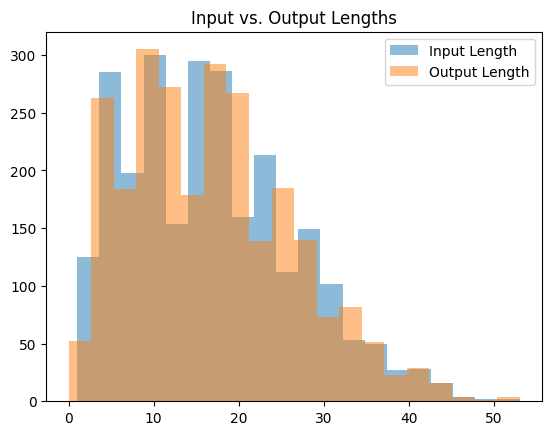

In [19]:
# Plot comparison (length distribution)
input_lens = [len(x.split()) for x in dataset["test"]["modern"]]
output_lens = [len(x.split()) for x in predictions]

plt.hist(input_lens, bins=20, alpha=0.5, label="Input Length")
plt.hist(output_lens, bins=20, alpha=0.5, label="Output Length")
plt.legend()
plt.title("Input vs. Output Lengths")
plt.show()